## Import the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn import tree


from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,recall_score, accuracy_score

## Read in the Data

In [2]:
water_df = pd.read_csv("water_potability.csv")

In [3]:
water_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## Exploratory Data Analysis and Preprocessing

In [4]:
water_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [5]:
water_df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

ph
Skew : 0.03


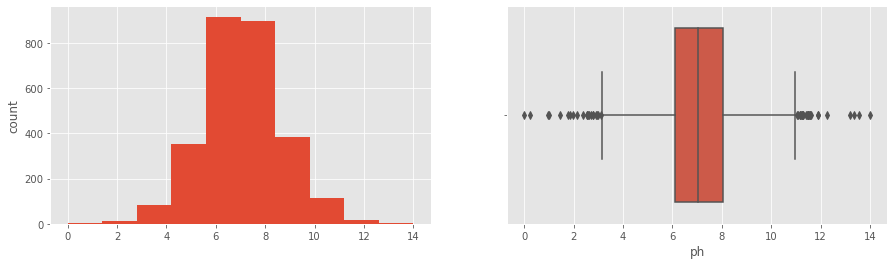

Hardness
Skew : -0.04


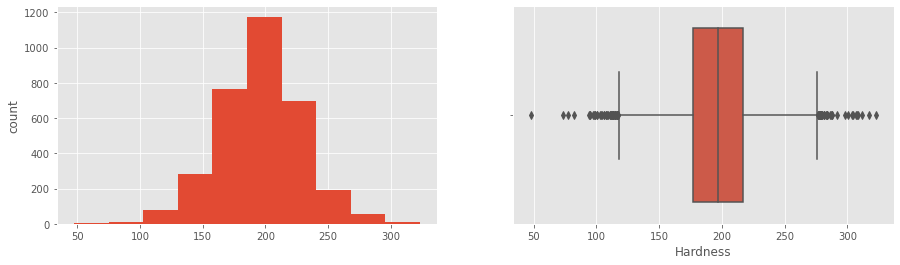

Solids
Skew : 0.62


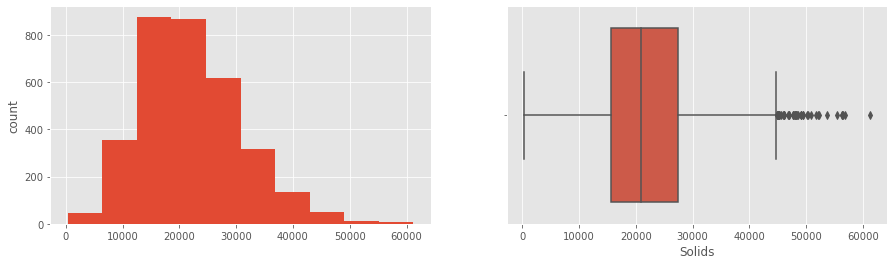

Chloramines
Skew : -0.01


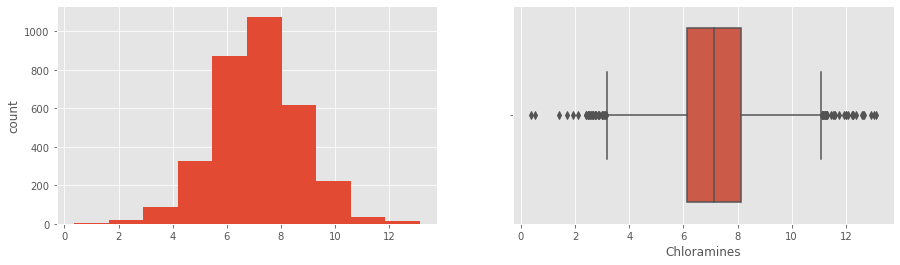

Sulfate
Skew : -0.04


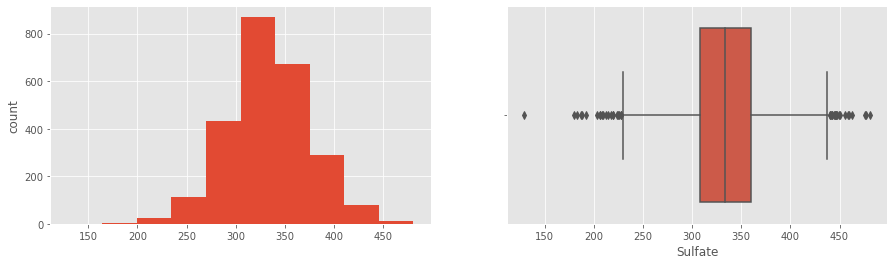

Conductivity
Skew : 0.26


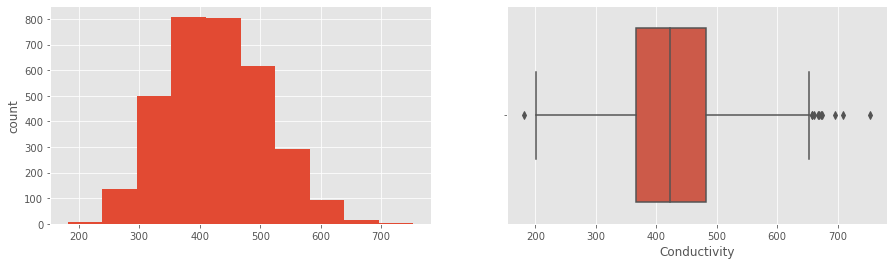

Organic_carbon
Skew : 0.03


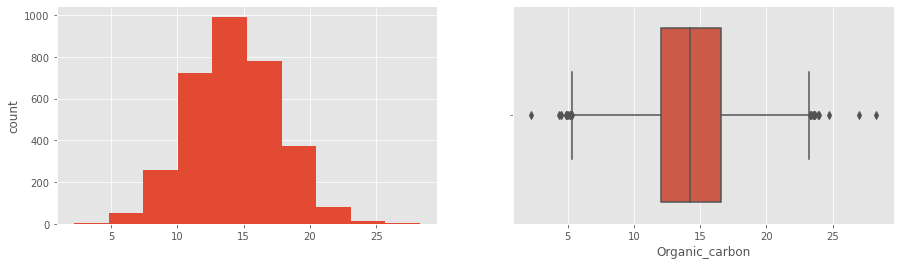

Trihalomethanes
Skew : -0.08


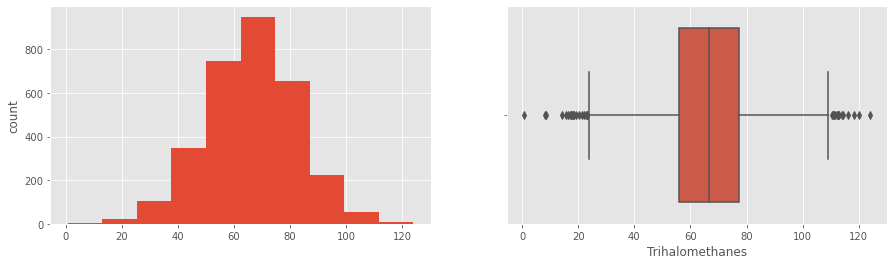

Turbidity
Skew : -0.01


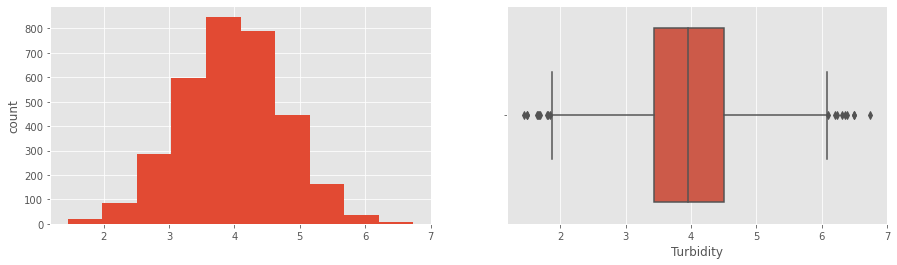

Potability
Skew : 0.45


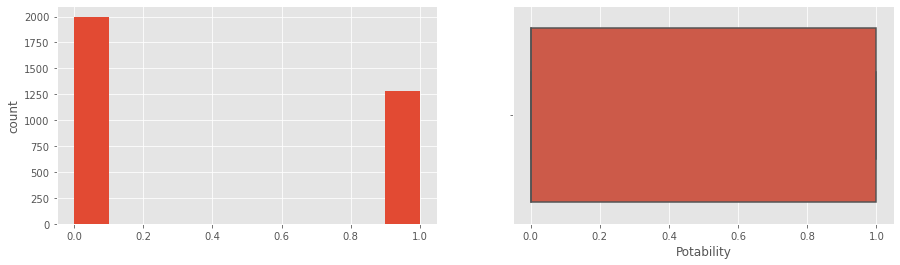

In [6]:
for col in water_df.columns:
    print(col)
    print('Skew :', round(water_df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    water_df[col].hist()
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x = water_df[col])
    plt.show();

It appears that all the independent variables are approximately normally distributed. Solids has a moderate right skew. The dependent variable, potability is binary. 

There are 491 missing values for ph, 781 missing values for Sulfates, and 162 missing values for Trihalomethanes. Because these three variables are normally distributed with very little skew, we can replace the missing values with the median.   

In [7]:
water_df['ph'].fillna(value=water_df['ph'].median(),inplace=True)
water_df['Sulfate'].fillna(value=water_df['Sulfate'].median(),inplace=True)
water_df['Trihalomethanes'].fillna(value=water_df['Trihalomethanes'].median(),inplace=True)

In [8]:
water_df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

There are no longer have any missing values

In [9]:
print(water_df['Potability'].value_counts(normalize = True))

0    0.60989
1    0.39011
Name: Potability, dtype: float64


61% of the samples were not potable, vs 39% that are potable. We will balence the dataaset now to avoid bias when running the decision tree.

In [10]:
water_df['Potability'].value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

In [11]:
not_pot  = water_df[water_df['Potability']==0]
pot = water_df[water_df['Potability']==1]  

from sklearn.utils import resample
df_minority_upsampled = resample(pot, replace = True, n_samples = 1200) 

from sklearn.utils import shuffle
water_df = pd.concat([not_pot, df_minority_upsampled])
water_df = shuffle(water_df) 

## Splitting the Data

In [12]:
X = water_df.drop('Potability',axis=1).values
y = water_df['Potability'].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
print("Shape of the training set: ", X_train.shape)   
print("Shape of the test set: ", X_test.shape)

Shape of the training set:  (2558, 9)
Shape of the test set:  (640, 9)


## Considering Precision and Recall

The model can make wrong predictions as:
1. Predicting water is potable when it is actually not potable.
2. Predicting water is not potable when it is actually potable. 

Which case is more important?

* If we predict that water is potable when it is not, someone could drink the water and get sick. 
* If we predict that the water is not potable when it actually is, there could be missed opportunity to utilize the water.

Someone getting sick is a greater potential loss.

How to reduce the losses?
* We want 'Precision' to be maximized. The greater the Precision score, the higher the chances of minimizing False Positives. 

**Precision: Out of all the samples we said were potable, how many were actually potable**

### Confusion matrix function: 

In [16]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize = (8, 5))
    sns.heatmap(cm, annot = True,  fmt = '.2f', xticklabels = ['Not Potable', 'Potable'], 
                yticklabels = ['Not Potable', 'Potable'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Decision Tree

* We will build our model using the **DecisionTreeClassifier function.** 
* If the frequency of Potable water (Class A) is 39% and the frequency of Unpotable Water (class B) is 61%, then class B will become the dominant class and **the decision tree will become biased toward the dominant class.**
* **class_weight is a hyperparameter** for the decision tree classifier, and in this case, we can pass a dictionary {0:0.39, 1:0.61} to the model to specify the weight of each class and the decision tree will give more weightage to class 1.

In [17]:
dt = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=5, random_state = 1)

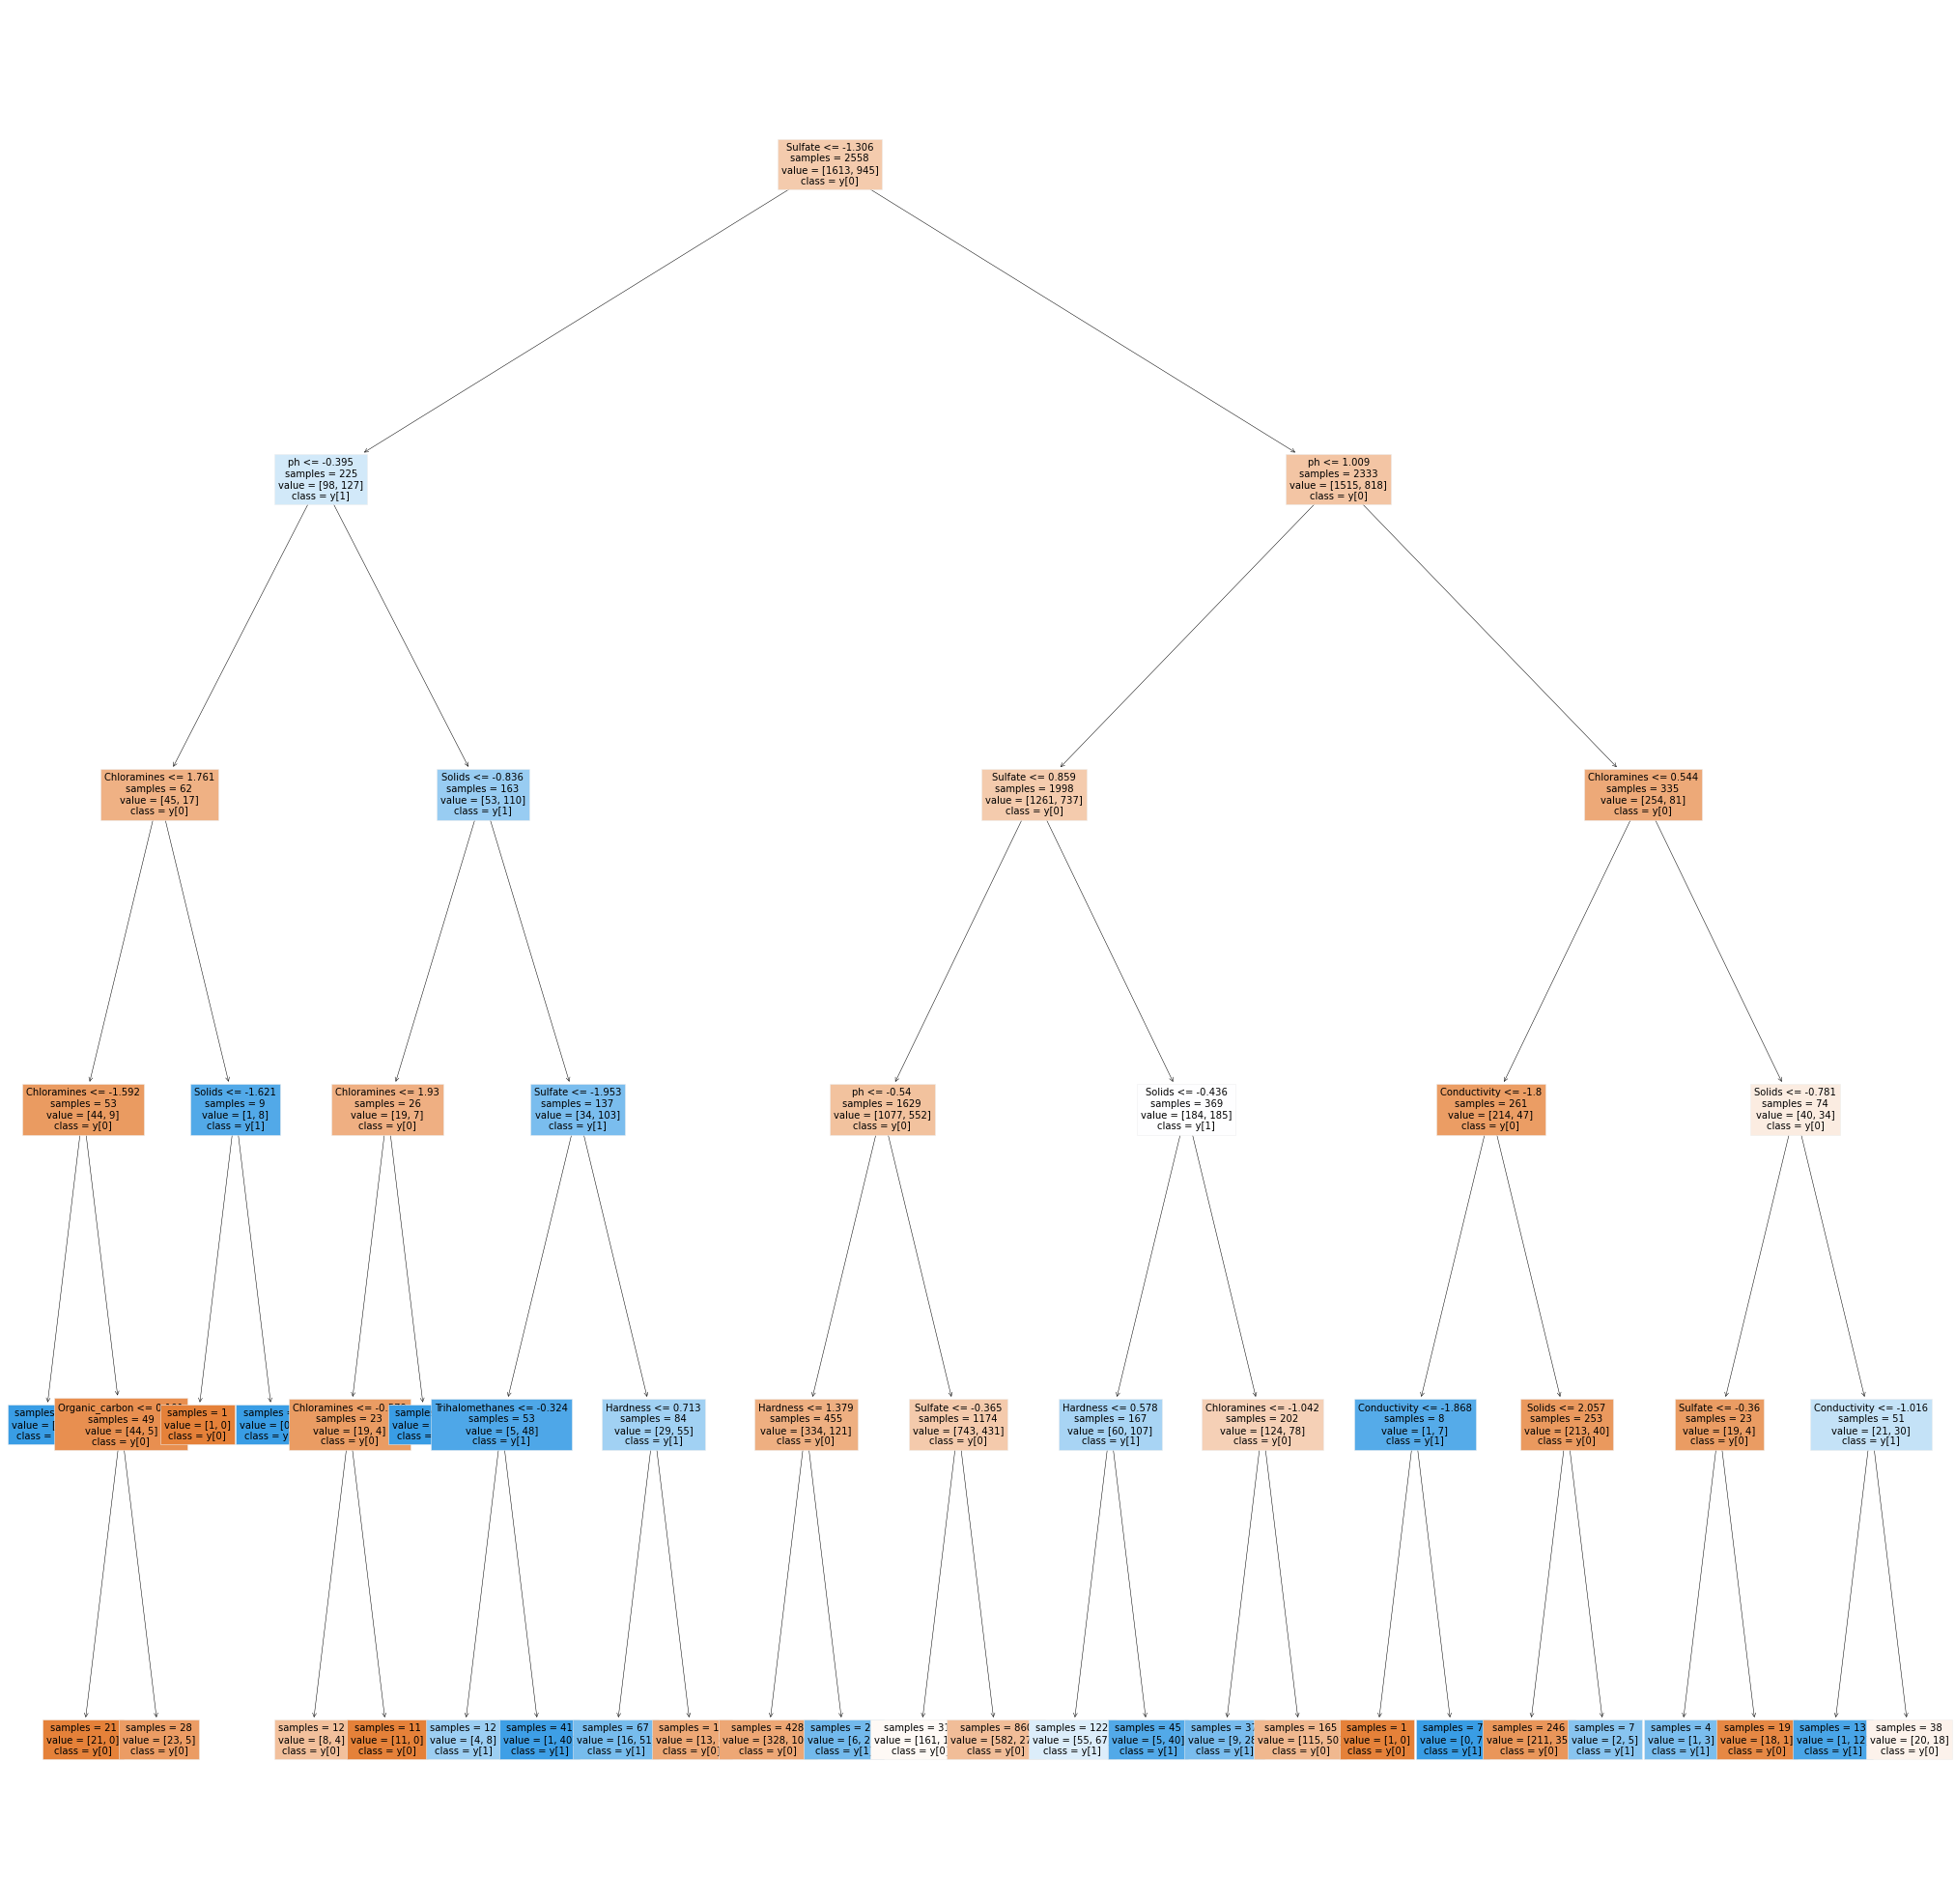

In [18]:
dt = dt.fit(X_train, y_train)
fig, ax = plt.subplots(figsize = (36, 36))
out = tree.plot_tree(dt, fontsize = 10, max_depth = 5, impurity = False, 
                     filled = True,feature_names = ['ph','Hardness','Solids', 'Chloramines','Sulfate',
                                                     'Conductivity','Organic_carbon','Trihalomethanes','Turbidity'], 
                     class_names = True)

Observations:
- We can see that the first split is based on sulfate content. It is one of the most important factors while figuring out if water is potable. 
- ph, solids, and hardness also play a role in the early splitting of the data.

Note: Blue color signifies potable = 1 and orange color signifies not potable = 0.

              precision    recall  f1-score   support

           0       0.70      0.94      0.80      1613
           1       0.75      0.31      0.44       945

    accuracy                           0.71      2558
   macro avg       0.72      0.63      0.62      2558
weighted avg       0.72      0.71      0.67      2558



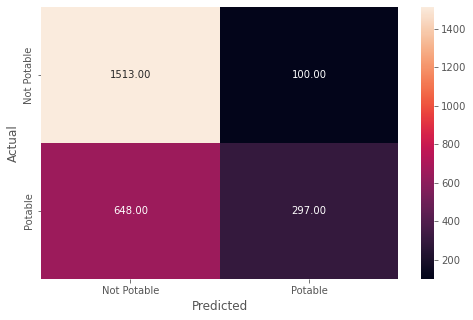

In [27]:
y_train_pred_dt = dt.predict(X_train)

metrics_score(y_train, y_train_pred_dt)

Observations:
- the precision of the model is 72%. 
- We will proceed with making a random forest to see if we can improve on the precision. 

## Random Forest

Instantiate the object and set the parameters we will use for grid search to find the optimal hyperparameters for the random forest classifier. 

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

params_rf = {'n_estimators':[100, 350, 500, 750], 'min_samples_leaf':[2, 10, 30]}
grid_rf = GridSearchCV(rf, param_grid=params_rf, cv=5)

Fit the model with the ideal grid search model

In [21]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [100, 350, 500, 750]})

Here we can see the ideal hyperparameters chosen for the random forest classifier.

In [22]:
print("Best parameters for Random Forest:", grid_rf.best_params_)

Best parameters for Random Forest: {'min_samples_leaf': 2, 'n_estimators': 750}


In [23]:
y_predict_rf = grid_rf.predict(X_train)
y_train_rf = grid_rf.predict(X_train)
accuracy = accuracy_score(y_train, y_train_rf)
print(accuracy)

0.9980453479280688


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1613
           1       1.00      0.99      1.00       945

    accuracy                           1.00      2558
   macro avg       1.00      1.00      1.00      2558
weighted avg       1.00      1.00      1.00      2558



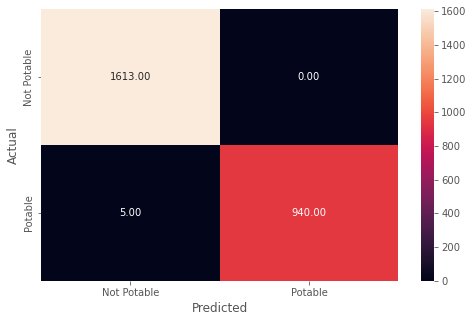

In [24]:
metrics_score(y_train, y_train_rf)

The random forest model is overfitting the data. To tell its performance we will need to test it on the test dataset and see if it performs better than the decision tree.

## Test the Random Forest Model

In [25]:
test_rf = grid_rf.predict(X_test)
accuracy = accuracy_score(y_test, test_rf)
print(accuracy)

0.8203125


Our random forest perfored with 82% accuracy on test data. 

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       385
           1       0.89      0.62      0.73       255

    accuracy                           0.82       640
   macro avg       0.84      0.79      0.80       640
weighted avg       0.83      0.82      0.81       640



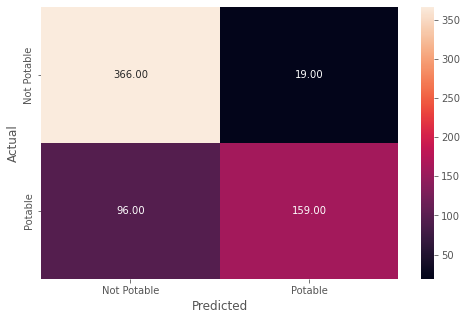

In [26]:
metrics_score(y_test, test_rf)

Our precision has increased from 79% to 89%. 